# Hyper Parameter Tuning of XG Boost,Gradient Boost and cross Validation

# Version 1.3 (Whole dataset is used, Concatination of 2 dataset)

# Please read this to understand the considerations of the Experiment

#### 1) In this experement the null values above 70% are dropped(for whole dataset). 
#### 2) For numerical features median is used to fill/handle the null values.
#### 3) 'REC_ID', 'HRPOSTMED', 'PDMEDTM', 'EVENT_ID', 'Unnamed:0', 'PDMEDDT', 'EXAMDT', 'PDSTATE', 'EXAMTM', 'INFODT' ,  'PDTRTMNT', 'ORIG_ENTRY',  'LAST_UPDATE'  These columns are dropped from the dataset

#### 4) pd.get_dummies(df_new) is used for encoding

#### 5) Finally for model traning various machine learning techniques are used to get the best model for this usecase

#### 6) It is observed that after hyper parameter tuning XG Boost gives increased accuracy of 90% ++

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import precision_score,recall_score, f1_score, accuracy_score,confusion_matrix,multilabel_confusion_matrix
import lime
from lime import lime_tabular


In [2]:
df1 = pd.read_csv("MDS-UPDRS_Part_III-Group-A.csv")
df2 = pd.read_csv("MDS-UPDRS_Part_III-Group-B.csv")
df = pd.concat([df1, df2], axis=0)

In [3]:
df['NHY'].value_counts()

2.0      10404
0.0       7861
1.0       3394
3.0        967
101.0      263
4.0        173
5.0         60
Name: NHY, dtype: int64

In [4]:
df_normalised = df.replace(101.,0.)

In [5]:
threshold = 70  # Set the threshold for missing values percentage

# Calculate the percentage of missing values for each column
null_values = df_normalised.isna().mean() * 100

# Identify columns with missing values greater than the threshold
columns_to_drop = null_values[null_values > threshold].index

# Drop the identified columns
df_normalised = df_normalised.drop(columns=columns_to_drop)

# Display the DataFrame after dropping columns
df_normalised

Unnamed: 0      REC_ID   PATNO EVENT_ID    PAG_NAME   INFODT  PDTRTMNT  \
0           17595   671077401   57869      V04     NUPDRS3  12/2017       1.0   
1           21551  IANT214603  111429       BL  NUPDRDOSE3  11/2022       0.0   
2           23302  IANT310558  182340       BL  NUPDRDOSE3  02/2023       0.0   
3           20789  IAON164829  101018      V02  NUPDRDOSE3  11/2021       1.0   
4           16024  IANT163527   52587      V12  NUPDRDOSE3  04/2021       0.0   
...           ...         ...     ...      ...         ...      ...       ...   
11960       17893  IAOF164017   58510      V08  NUPDRDOSE3  03/2021       1.0   
11961         720   532644601    3069      V10     NUPDRS3  08/2015       NaN   
11962       22646  IANT165575  153027       BL  NUPDRDOSE3  08/2022       0.0   
11963       18553   478056701   60043      V02     NUPDRS3  11/2014       0.0   
11964        3195  IANT162050    3318      R16  NUPDRDOSE3  02/2022       0.0   

      PDSTATE  HRPOSTMED  PDMEDYN  ...  NP3RTALU NP3RTARL NP3RTALL NP3RTALJ  \
0         OFF    14.5000      1.0  ...       1.0      2.0      3.0      0.0   
1         NaN        NaN      0.0  ...       0.0      0.0      0.0      0.0   
2         NaN        NaN      0.0  ...       1.0      0.0      0.0      0.0   
3          ON     3.0833      1.0  ...       0.0      0.0      0.0      0.0   
4         NaN        NaN      0.0  ...       0.0      0.0      0.0      0.0   
...       ...        ...      ...  ...       ...      ...      ...      ...   
11960     OFF        NaN      1.0  ...       NaN      NaN      NaN      NaN   
11961     NaN        NaN      NaN  ...       0.0      0.0      0.0      0.0   
11962     NaN        NaN      NaN  ...       0.0      0.0      0.0      0.0   
11963     NaN        NaN      0.0  ...       0.0      0.0      0.0      0.0   
11964     NaN        NaN      NaN  ...       0.0      0.0      0.0      0.0   

      NP3RTCON  NP3TOT  DYSKPRES  NHY  ORIG_ENTRY            LAST_UPDATE  
0          0.0    54.0       0.0  2.0     01/2018  2018-01-11 15:46:02.0  
1          0.0     0.0       0.0  0.0     12/2022  2022-12-20 00:00:00.0  
2          1.0    16.0       0.0  1.0     08/2023  2023-08-09 00:00:00.0  
3          0.0    15.0       0.0  2.0     11/2021  2021-11-16 00:00:00.0  
4          0.0     0.0       0.0  0.0     05/2021  2021-05-04 00:00:00.0  
...        ...     ...       ...  ...         ...                    ...  
11960      NaN     NaN       NaN  NaN     03/2021  2021-03-23 00:00:00.0  
11961      0.0     1.0       0.0  0.0     08/2015  2020-06-24 12:34:50.0  
11962      0.0    18.0       0.0  1.0     09/2022  2022-09-01 00:00:00.0  
11963      0.0     0.0       0.0  0.0     11/2014  2020-01-24 15:33:29.0  
11964      0.0     NaN       0.0  2.0     02/2022  2022-02-09 00:00:00.0  

[23929 rows x 53 columns]

In [6]:
# Identify numerical columns with missing values
numerical_columns_with_missing = df_normalised.select_dtypes(include='number').columns[df_normalised.select_dtypes(include='number').isnull().any()]

# Replace missing values with median for each numerical column
for column in numerical_columns_with_missing:
    median_value = df_normalised[column].median()  #Try using mode to see the change 
    df_normalised[column].fillna(median_value, inplace=True)

    
# Filling the null values with median

In [7]:
df_new = df_normalised.drop(['REC_ID','HRPOSTMED','PDMEDTM','EVENT_ID','Unnamed: 0','PDMEDDT','EXAMDT','PDSTATE','EXAMTM','INFODT', 'PDTRTMNT','ORIG_ENTRY', 'LAST_UPDATE'],axis = 1)

In [8]:
df_new = pd.get_dummies(df_new)

In [9]:
df_new.columns

Index(['PATNO', 'PDMEDYN', 'DBSYN', 'NP3SPCH', 'NP3FACXP', 'NP3RIGN',
       'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL',
       'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR', 'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL',
       'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL',
       'NP3POSTR', 'NP3BRADY', 'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR', 'NP3KTRML',
       'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON',
       'NP3TOT', 'DYSKPRES', 'NHY', 'PAG_NAME_NUPDR3OF', 'PAG_NAME_NUPDR3ON',
       'PAG_NAME_NUPDRDOSE3', 'PAG_NAME_NUPDRS3', 'PAG_NAME_NUPDRS3A'],
      dtype='object')

In [10]:
df_new.shape

(23929, 44)

In [11]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_new, test_size=0.3, random_state=0)

In [12]:
train['NHY'].unique()

array([2., 0., 1., 5., 3., 4.])

In [13]:
x_train=train.drop('NHY',axis=1)
y_train=train['NHY']

x_test=test.drop('NHY',axis=1)
y_test=test['NHY']

In [14]:
y_train.value_counts() # Highly Imbalanced

2.0    7790
0.0    5698
1.0    2396
3.0     702
4.0     124
5.0      40
Name: NHY, dtype: int64

from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
# Define SMOTE-Tomek Links
resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
x_train, y_train = resample.fit_resample(x_train, y_train)

In [15]:
y_test.value_counts()

2.0    3421
0.0    2426
1.0     998
3.0     265
4.0      49
5.0      20
Name: NHY, dtype: int64

In [16]:
y_test.shape

(7179,)

# HyperParameter Tuning

# Model Traning

In [17]:
!pip install xgboost

In [18]:
print(x_train.shape)

(16750, 43)


import xgboost as xgb
XGB_model = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 7, n_estimators = 60, min_samples_split = 4,min_samples_leaf=3,subsample=1)
XGB_model.fit(x_train, y_train)

In [19]:
import xgboost as xgb
XGB_model = xgb.XGBClassifier(colsample_bytree =  0.9, learning_rate = 0.2, max_depth = 5, min_child_weight =  1, n_estimators = 300, subsample = 0.9)
XGB_model.fit(x_train, y_train)

C:\Users\utkar\anaconda3\envs\tfgpu\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:23:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [44]:
XG_pred_prob = XGB_model.predict_proba(x_test)
XG_pred = XGB_model.predict(x_test)
XG_pred_train = XGB_model.predict(x_train)
XGB_result_test = XGB_model.score(x_test,y_test)
print("Accuracy on test : {}".format(XGB_result_test))

XGB_result_train = XGB_model.score(x_train,y_train)
print("Accuracy on train: {}".format(XGB_result_train))

Accuracy on test : 0.9304917119375957
Accuracy on train: 0.9905671641791045


F1-score:  0.8464242131516208
Precision:  0.8915299694608186
Recall:  0.8112647388395743


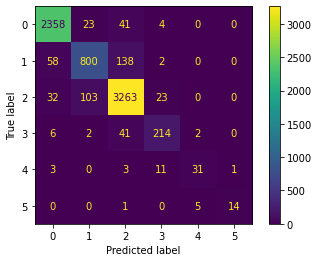

In [21]:
display_labels = ["0", "1", "2", "3", "4", "5"]
cmap = "Blues"
colorbar = False
values_format = ".3f"
title_size = 16

#XGB
XGB_cm = confusion_matrix(y_test, XG_pred)
print("F1-score: ",f1_score(y_test, XG_pred, average="macro"))
print("Precision: ",precision_score(y_test, XG_pred, average="macro"))
print("Recall: ",recall_score(y_test, XG_pred, average="macro"))
ConfusionMatrixDisplay(confusion_matrix=XGB_cm, display_labels=display_labels).plot()

# K-Fold Cross validation

In [22]:
data_dmatrix = xgb.DMatrix(data=x_train,label=y_train)

In [23]:
from xgboost import cv

params = {"objective":'multi:softmax','colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 7, 'alpha': 10, 'n_estimators':60,'num_class':6}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

[09:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  Thi

In [24]:
xgb_cv.head()

train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.900042       0.002853       0.892870      0.002323
1        0.928068       0.003274       0.922295      0.003215
2        0.941862       0.004998       0.936976      0.002167
3        0.948968       0.001908       0.944727      0.001506
4        0.953620       0.001886       0.949595      0.001931

# Feature Importance of XG Boost

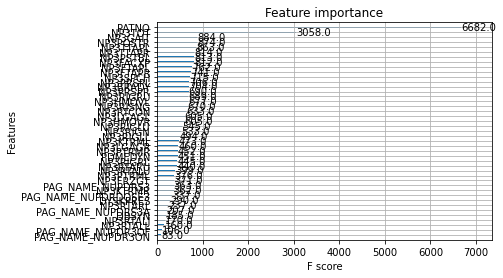

In [25]:
xgb.plot_importance(XGB_model)
#plt.rcParams['figure.figsize'] = [10, 15]
plt.show()

In [26]:

import warnings
from lime import submodular_pick

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(x_train),
    feature_names=x_train.columns,
    class_names= ["0", "1", "2", "3", "4", "5"],
    mode='classification')

exp = explainer.explain_instance(
    data_row=x_train.iloc[1], 
    predict_fn=XGB_model.predict_proba,
    top_labels=6)
exp.show_in_notebook(show_table=True)

# Gradient Boosting Hyperparameter tuning

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

In [28]:
model4 = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 7, n_estimators = 60, min_samples_split = 4,min_samples_leaf=3,subsample=1)

In [29]:
model4.fit(x_train,y_train)

GradientBoostingClassifier(max_depth=7, min_samples_leaf=3, min_samples_split=4,
                           n_estimators=60, subsample=1)

In [30]:
pred4_proba=model4.predict_proba(x_test)
pred4=model4.predict(x_test)
testaccuracy4= model4.score(x_test, y_test)
print("Accuracy of GBC test  : {} %".format(round((testaccuracy4*100),2)))

Accuracy of GBC test  : 91.35 %


In [73]:
predgbc=model4.predict(x_test)

In [31]:
print(x_train.shape)

(16750, 43)


In [32]:
train_pred4_proba=model4.predict_proba(x_train)
train_pred4=model4.predict(x_train)
trainaccuracy4= model4.score(x_train, y_train)
print("Accuracy of GBC train  : {} %".format(round((trainaccuracy4*100),2)))

Accuracy of GBC train  : 97.64 %


F1-score:  0.7718424348673686
Precision:  0.7893805664659675
Recall:  0.7584335812573021


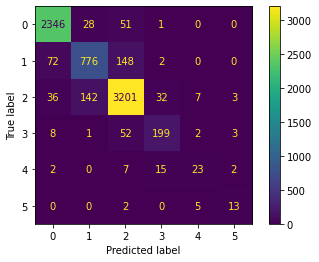

In [33]:
#GBC
cm4 = confusion_matrix(y_test, pred4)
print("F1-score: ",f1_score(y_test, pred4, average="macro"))
print("Precision: ",precision_score(y_test, pred4, average="macro"))
print("Recall: ",recall_score(y_test, pred4, average="macro"))
ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels=display_labels).plot()

In [34]:
exp = explainer.explain_instance(
    data_row=x_test.iloc[1], 
    predict_fn=model4.predict_proba,
    top_labels=6)
exp.show_in_notebook(show_table=True)
#exp.save_to_file('lime_explanation.html')


# AdaBoost

In [35]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth = 7,min_samples_split = 4,min_samples_leaf=3)
# Create adaboost classifer object
abc =AdaBoostClassifier(n_estimators=80, base_estimator=dt,learning_rate=1)

# Train Adaboost Classifer
model = abc.fit(x_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(x_test)


# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.8506755815573199


In [36]:
pred_proba=model.predict_proba(x_test)
pred4=model.predict(x_test)
testaccuracy= model.score(x_test, y_test)
print("Accuracy of AdaBoost test  : {} %".format(round((testaccuracy*100),2)))

Accuracy of AdaBoost test  : 85.07 %


In [37]:
print(x_train.shape)

(16750, 43)


In [38]:
train_pred_proba=model.predict_proba(x_train)
train_pred=model.predict(x_train)
trainaccuracy= model.score(x_train, y_train)
print("Accuracy of AdaBoost train  : {} %".format(round((trainaccuracy*100),2)))

Accuracy of AdaBoost train  : 89.27 %


F1-score:  0.7473336158509825
Precision:  0.8358500849042504
Recall:  0.6976254269062651


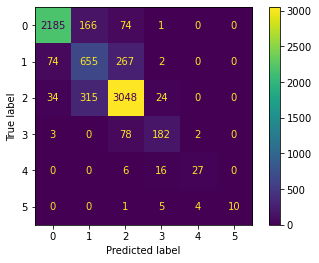

In [39]:
#Adaboost
cm = confusion_matrix(y_test, pred4)
print("F1-score: ",f1_score(y_test, y_pred, average="macro"))
print("Precision: ",precision_score(y_test, y_pred, average="macro"))
print("Recall: ",recall_score(y_test, y_pred, average="macro"))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels).plot()

In [40]:
exp = explainer.explain_instance(
    data_row=x_test.iloc[1], 
    predict_fn=model.predict_proba,
    top_labels=6)
exp.show_in_notebook(show_table=True)

In [46]:
print(len(XG_pred_train))
print(len(train_pred4))
print(len(train_pred))

16750
16750
16750


In [48]:
p_df = pd.DataFrame({'xgb': XG_pred_train, 'gbc': train_pred4, 'adb': train_pred})

In [74]:
p_df_t = pd.DataFrame({'xgb': XG_pred, 'gbc': predgbc, 'adb': pred4})

In [75]:
p_df_t

xgb  gbc  adb
0     0.0  0.0  1.0
1     0.0  0.0  0.0
2     2.0  2.0  2.0
3     0.0  0.0  0.0
4     0.0  0.0  2.0
...   ...  ...  ...
7174  2.0  2.0  2.0
7175  2.0  2.0  2.0
7176  1.0  2.0  2.0
7177  2.0  2.0  2.0
7178  0.0  0.0  0.0

[7179 rows x 3 columns]

In [49]:
p_df

xgb  gbc  adb
0      2.0  2.0  2.0
1      0.0  0.0  1.0
2      2.0  2.0  2.0
3      2.0  2.0  2.0
4      0.0  0.0  0.0
...    ...  ...  ...
16745  0.0  0.0  1.0
16746  2.0  2.0  2.0
16747  2.0  2.0  2.0
16748  0.0  0.0  0.0
16749  0.0  0.0  0.0

[16750 rows x 3 columns]

In [56]:
p_dfe = pd.read_csv("ensemble.csv")

In [76]:
p_dfe_t = pd.read_csv("ensemble_t.csv")

In [68]:
p_dfe

sc   vc  bgc   rf
0       2  2.0  2.0  2.0
1       0  2.0  2.0  2.0
2       2  2.0  2.0  2.0
3       2  2.0  2.0  2.0
4       0  0.0  0.0  0.0
...    ..  ...  ...  ...
16745   0  0.0  0.0  0.0
16746   2  2.0  2.0  2.0
16747   2  2.0  2.0  2.0
16748   0  0.0  0.0  0.0
16749   0  0.0  0.0  0.0

[16750 rows x 4 columns]

In [69]:
p_df

xgb  gbc  adb
0      2.0  2.0  2.0
1      0.0  0.0  1.0
2      2.0  2.0  2.0
3      2.0  2.0  2.0
4      0.0  0.0  0.0
...    ...  ...  ...
16745  0.0  0.0  1.0
16746  2.0  2.0  2.0
16747  2.0  2.0  2.0
16748  0.0  0.0  0.0
16749  0.0  0.0  0.0

[16750 rows x 3 columns]

In [78]:
p_dfe_t

sc   vc  bgc   rf
0      0  0.0  0.0  0.0
1      0  0.0  0.0  0.0
2      2  2.0  2.0  2.0
3      0  0.0  0.0  0.0
4      2  2.0  2.0  2.0
...   ..  ...  ...  ...
7174   2  2.0  2.0  2.0
7175   2  2.0  2.0  2.0
7176   2  2.0  2.0  2.0
7177   2  2.0  2.0  2.0
7178   0  0.0  0.0  0.0

[7179 rows x 4 columns]

In [ ]:
p_dfe=p_dfe.drop(columns=['Unnamed: 0'])

In [80]:
new_p = pd.concat([p_df,p_dfe],axis = 1)
new_t = pd.concat([p_df_t,p_dfe_t],axis = 1)

In [72]:
new_p

xgb  gbc  adb  sc   vc  bgc   rf
0      2.0  2.0  2.0   2  2.0  2.0  2.0
1      0.0  0.0  1.0   0  2.0  2.0  2.0
2      2.0  2.0  2.0   2  2.0  2.0  2.0
3      2.0  2.0  2.0   2  2.0  2.0  2.0
4      0.0  0.0  0.0   0  0.0  0.0  0.0
...    ...  ...  ...  ..  ...  ...  ...
16745  0.0  0.0  1.0   0  0.0  0.0  0.0
16746  2.0  2.0  2.0   2  2.0  2.0  2.0
16747  2.0  2.0  2.0   2  2.0  2.0  2.0
16748  0.0  0.0  0.0   0  0.0  0.0  0.0
16749  0.0  0.0  0.0   0  0.0  0.0  0.0

[16750 rows x 7 columns]

In [81]:
new_t

xgb  gbc  adb  sc   vc  bgc   rf
0     0.0  0.0  1.0   0  0.0  0.0  0.0
1     0.0  0.0  0.0   0  0.0  0.0  0.0
2     2.0  2.0  2.0   2  2.0  2.0  2.0
3     0.0  0.0  0.0   0  0.0  0.0  0.0
4     0.0  0.0  2.0   2  2.0  2.0  2.0
...   ...  ...  ...  ..  ...  ...  ...
7174  2.0  2.0  2.0   2  2.0  2.0  2.0
7175  2.0  2.0  2.0   2  2.0  2.0  2.0
7176  1.0  2.0  2.0   2  2.0  2.0  2.0
7177  2.0  2.0  2.0   2  2.0  2.0  2.0
7178  0.0  0.0  0.0   0  0.0  0.0  0.0

[7179 rows x 7 columns]

In [91]:
meta_model = DecisionTreeClassifier()
meta_model.fit(new_p,y_train)

DecisionTreeClassifier()

In [92]:
meta_model.score(new_p,y_train)

0.9996417910447761

In [93]:
meta_model.score(new_t,y_test)

0.9224125922830477